# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import torch
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict
from PIL import Image

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
validation_dataset = datasets.ImageFolder(valid_dir, transform=validation_transforms)
test_dataset = datasets.ImageFolder(test_dir ,transform = test_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

<font color='red'>**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.</font>

In [5]:
dropout=0.5

def model_setup(dropout=0.5):
    
    # Number of output units from the vgg16
    vgg16 = 25088
    
    model = models.vgg16(pretrained=True)  

    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False

    from collections import OrderedDict
    classifier = nn.Sequential(OrderedDict([
                                  ('dropout',nn.Dropout(dropout)),
                                  ('inputs', nn.Linear(vgg16, 100)),
                                  ('relu1', nn.ReLU()),
                                  ('hidden_layer_1', nn.Linear(100, 90)),
                                  ('relu2',nn.ReLU()),
                                  ('hidden_layer_2',nn.Linear(90, 80)),
                                  ('relu3',nn.ReLU()),
                                  ('hidden_layer_3',nn.Linear(80, 102)),
                                  ('output', nn.LogSoftmax(dim=1))
                              ]))

    model.classifier = classifier

    return model

model = model_setup(dropout)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 105227915.91it/s]


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [6]:
# Get GPU/CPU automatically
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
criterion = nn.NLLLoss()

learning_rate=0.001
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate )

model.to(device)

epochs = 10
print_every = 6 # every 6 batches
steps = 0

train_losses, validation_losses = [], []
for e in range(epochs):
    running_loss = 0
    
    for ii, (train_inputs, train_labels) in enumerate(train_loader):
        steps += 1

        # Move input and label tensors to the GPU (if available)
        train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)
        
        optimizer.zero_grad()

        # Forward and backward passes
        outputs = model.forward(train_inputs)
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        if steps % print_every == 0:
            # Deactivate dropout
            model.eval()
            validation_loss = 0
            accuracy = 0
            
            for ii, (validation_inputs, validation_labels) in enumerate(validation_loader):
                optimizer.zero_grad()
                
                # We will keep using the training hardware for validation (cuda or cpu)
                validation_inputs, validation_labels = validation_inputs.to(device), validation_labels.to(device)
                model.to(device)
                
                with torch.no_grad():    
                    outputs = model.forward(validation_inputs)
                    validation_loss = criterion(outputs, validation_labels)
                    ps = torch.exp(outputs).data 
                    equality = (validation_labels.data == ps.max(1)[1])
                    accuracy += equality.type_as(torch.FloatTensor()).mean()
                    
            validation_loss = validation_loss / len(validation_loader)
            train_loss = running_loss / len(train_loader)
            
            train_losses.append(train_loss)
            validation_losses.append(validation_loss)
            
            accuracy = accuracy /len(validation_loader)
            
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every),
                  "Validation Loss {:.4f}".format(validation_loss),
                  "Accuracy: {:.4f}".format(accuracy))
            
            running_loss = 0

Epoch: 1/10...  Loss: 4.5788 Validation Loss 0.3486 Accuracy: 0.0314
Epoch: 1/10...  Loss: 4.4741 Validation Loss 0.3383 Accuracy: 0.0862
Epoch: 1/10...  Loss: 4.3598 Validation Loss 0.3227 Accuracy: 0.1201
Epoch: 1/10...  Loss: 4.2279 Validation Loss 0.3048 Accuracy: 0.1734
Epoch: 1/10...  Loss: 4.0707 Validation Loss 0.2953 Accuracy: 0.1612
Epoch: 1/10...  Loss: 3.7556 Validation Loss 0.2485 Accuracy: 0.1909
Epoch: 1/10...  Loss: 3.5711 Validation Loss 0.2473 Accuracy: 0.3200
Epoch: 1/10...  Loss: 3.3486 Validation Loss 0.2539 Accuracy: 0.3138
Epoch: 1/10...  Loss: 3.0433 Validation Loss 0.1950 Accuracy: 0.3992
Epoch: 1/10...  Loss: 3.0248 Validation Loss 0.1824 Accuracy: 0.4106
Epoch: 1/10...  Loss: 2.7554 Validation Loss 0.1745 Accuracy: 0.4526
Epoch: 1/10...  Loss: 2.6233 Validation Loss 0.1522 Accuracy: 0.4686
Epoch: 1/10...  Loss: 2.4477 Validation Loss 0.1579 Accuracy: 0.5240
Epoch: 1/10...  Loss: 2.3322 Validation Loss 0.1241 Accuracy: 0.5199
Epoch: 1/10...  Loss: 2.0721 Valid

Epoch: 8/10...  Loss: 0.5235 Validation Loss 0.0359 Accuracy: 0.8426
Epoch: 8/10...  Loss: 0.6707 Validation Loss 0.0476 Accuracy: 0.8503
Epoch: 8/10...  Loss: 0.7643 Validation Loss 0.0221 Accuracy: 0.8548
Epoch: 8/10...  Loss: 0.6908 Validation Loss 0.0310 Accuracy: 0.8505
Epoch: 8/10...  Loss: 0.7231 Validation Loss 0.0442 Accuracy: 0.8474
Epoch: 8/10...  Loss: 0.8082 Validation Loss 0.0453 Accuracy: 0.8413
Epoch: 8/10...  Loss: 0.8419 Validation Loss 0.0570 Accuracy: 0.8364
Epoch: 8/10...  Loss: 0.6972 Validation Loss 0.0486 Accuracy: 0.8419
Epoch: 8/10...  Loss: 0.6888 Validation Loss 0.0540 Accuracy: 0.8400
Epoch: 8/10...  Loss: 0.7703 Validation Loss 0.0444 Accuracy: 0.8622
Epoch: 8/10...  Loss: 0.7613 Validation Loss 0.0156 Accuracy: 0.8614
Epoch: 8/10...  Loss: 0.7389 Validation Loss 0.0228 Accuracy: 0.8628
Epoch: 8/10...  Loss: 0.7618 Validation Loss 0.0313 Accuracy: 0.8666
Epoch: 8/10...  Loss: 0.6777 Validation Loss 0.0370 Accuracy: 0.8649
Epoch: 8/10...  Loss: 0.6821 Valid

In [7]:
# Check accuracy on test dataset

accuracy = 0

for ii, (test_inputs, test_labels) in enumerate(test_loader):
    # Move input and label tensors to the GPU (if available)
    test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

    # Get the class probabilities
    ps = torch.exp(model(test_inputs))
    
    # Make sure the shape is appropriate, we should get 102 class probabilities for 64 examples
    top_p, top_class = ps.topk(1, dim=1)
    
    # Look at the most likely classes for the first 10 examples
    equals = top_class == test_labels.view(*top_class.shape)
    
    accuracy += torch.mean(equals.type(torch.FloatTensor))
    
accuracy = accuracy /len(test_loader)
print(f'Accuracy of the network on the test images: {accuracy.item()*100}%')

Accuracy of the network on the test images: 87.7073884010315%


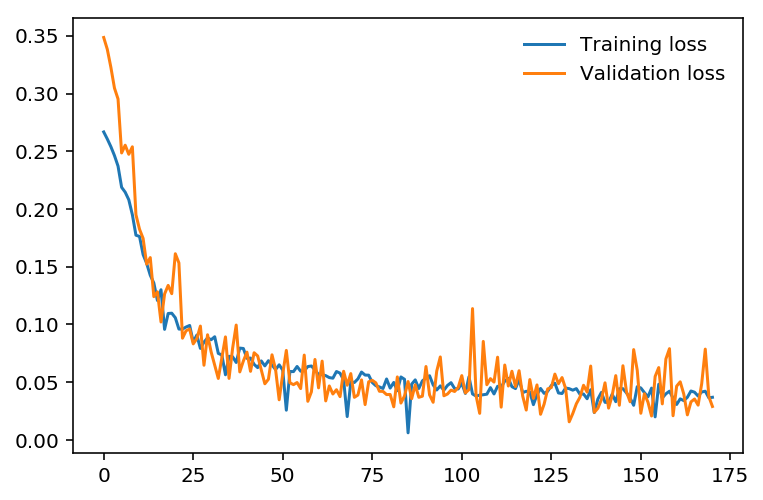

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend(frameon=False)

In [9]:
model.class_to_idx = train_dataset.class_to_idx

torch.save({'dropout': dropout,
            'learning_rate': learning_rate,
            'state_dict': model.state_dict(),
            'class_to_idx': model.class_to_idx},
            'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [10]:
def load_model(path):
    checkpoint = torch.load('checkpoint.pth')
    dropout = checkpoint['dropout']
    model = model_setup(dropout)
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

model = load_model('checkpoint.pth')

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [11]:
def process_image(image):

    adjustments = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return adjustments(Image.open(image))

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

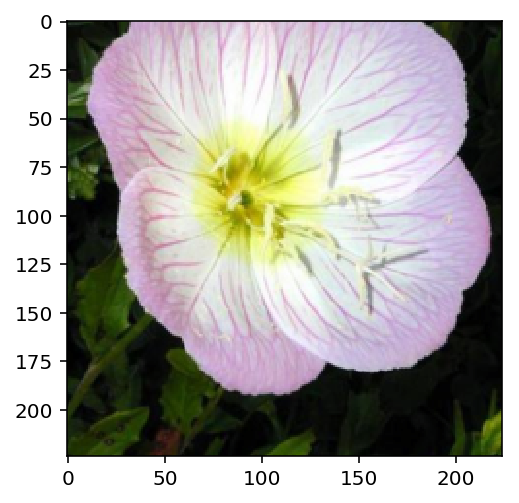

In [12]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    image = std * image + mean
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

imshow(process_image("flowers/test/1/image_06743.jpg"))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [13]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.to('cuda:0')
    img_torch = process_image(image_path)
    img_torch = img_torch.unsqueeze_(0).float()
    
    with torch.no_grad():
        output = model.forward(img_torch.cuda())
        
    probability = F.softmax(output.data,dim=1)
    
    return probability.topk(topk)

img = ("flowers/test/10/image_07104.jpg")
predict(img, model)

(tensor([[ 9.9313e-01,  6.7333e-03,  1.0006e-04,  2.2689e-05,  8.0200e-06]], device='cuda:0'),
 tensor([[  1,   8,  24,   6,  31]], device='cuda:0'))

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

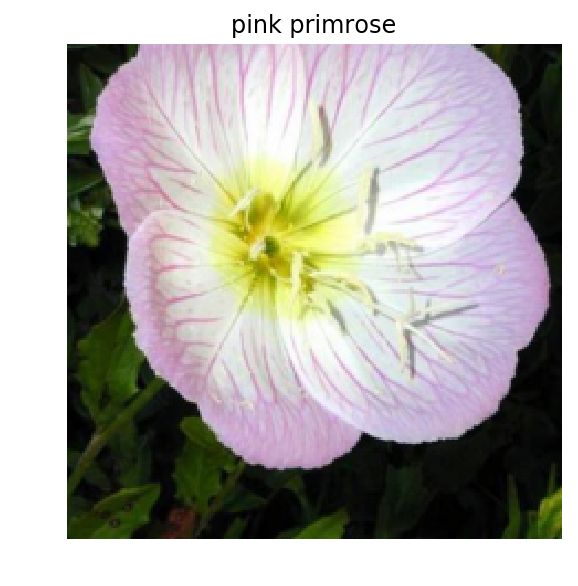

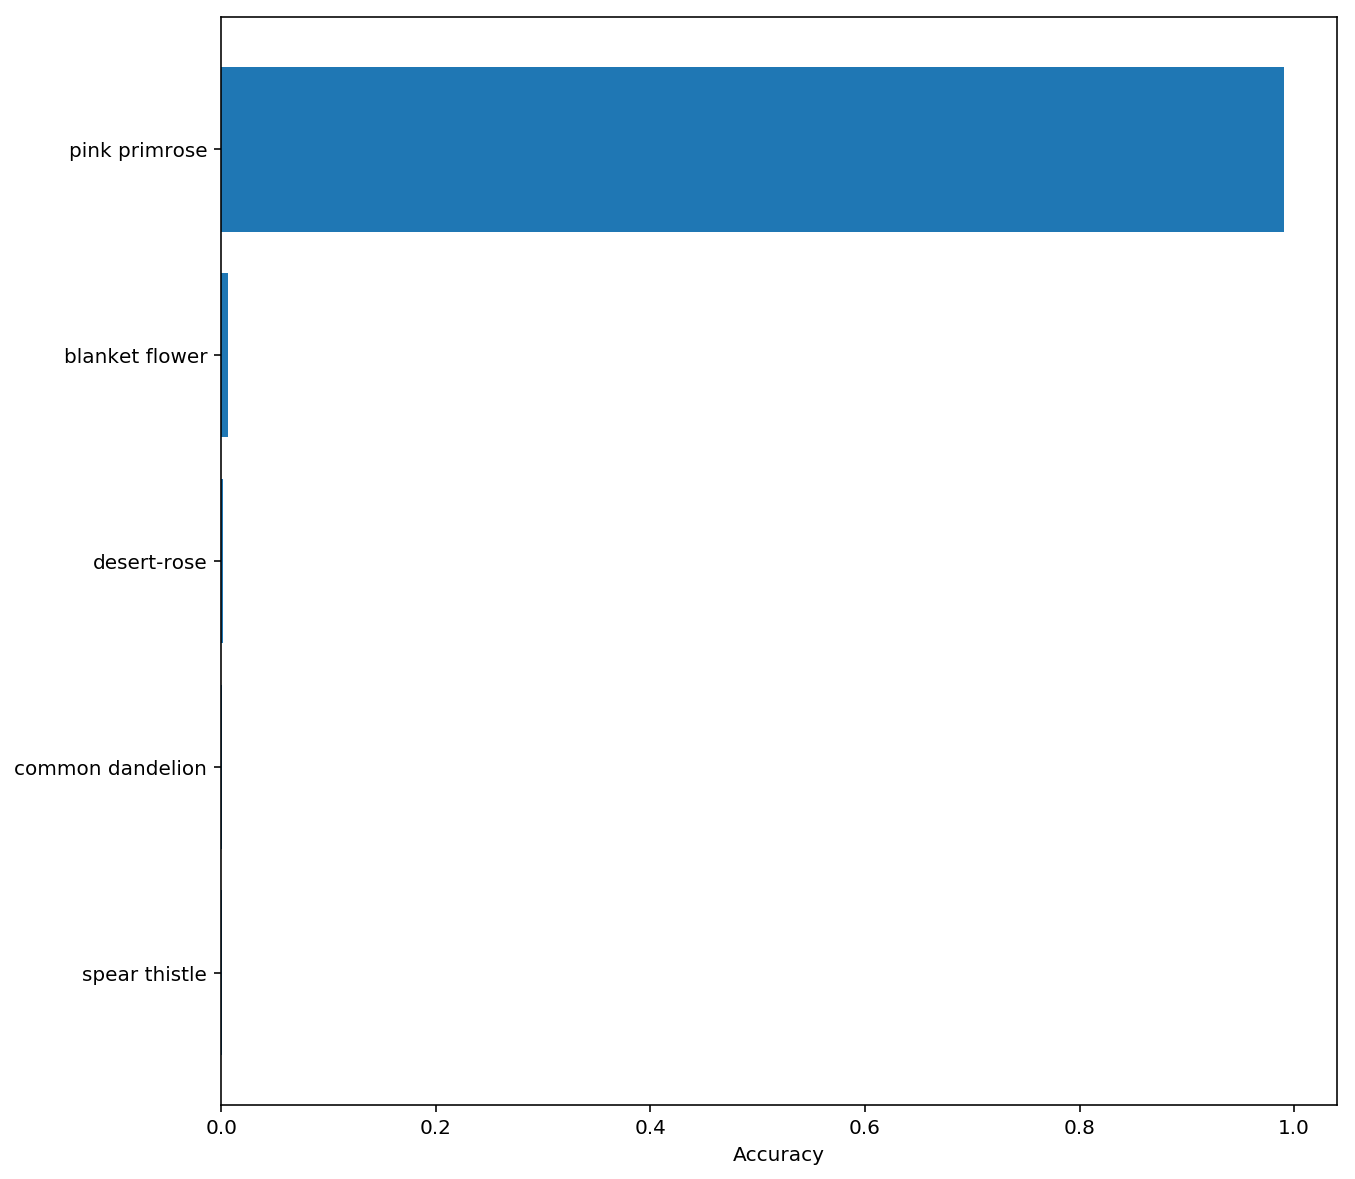

In [14]:
def check_sanity(path):    
    probabilities = predict(path, model)
    
    # Plotting a flower image
    plt.rcParams["figure.figsize"] = (10,10)
    plt.subplot(211)
    image = process_image(path)
    flower_axs = imshow(image, ax = plt)
    flower_axs.axis('off')
    index = 1
    flower_axs.title(cat_to_name[str(index)])
    flower_axs.show()
    
    # Separating labels and probabilities
    top_probabilities = np.array(probabilities[0][0].cpu().numpy())
    top_label_probabilities = [cat_to_name[str(index + 1)] for index in np.array(probabilities[1][0].cpu().numpy())]
    
    # Plotting graph with all labels
    fig, graph_ax = plt.subplots(figsize=(10,10))
    y_pos = np.arange(float(len(top_probabilities)))
    graph_ax.barh(y_pos, top_probabilities, align='center')
    graph_ax.set_yticks(y_pos)
    graph_ax.set_yticklabels(top_label_probabilities)
    graph_ax.invert_yaxis()  # labels read top-to-bottom
    graph_ax.set_xlabel('Accuracy')  

    plt.show()

check_sanity(path='flowers/test/1/image_06743.jpg')

<font color='red'>**Reminder for Workspace users:** If your network becomes very large when saved as a checkpoint, there might be issues with saving backups in your workspace. You should reduce the size of your hidden layers and train again. 
    
We strongly encourage you to delete these large interim files and directories before navigating to another page or closing the browser tab.</font>

In [2]:
# TODO remove .pth files or move it to a temporary `~/opt` directory in this Workspace